In [1]:
import tensorflow as tf
import numpy as np
from tensorflow_vgg.utils import load_image, print_prob
from nbutil import imshow_multi, to_pil
import random
import scipy

def rand_variable(shape, stddev=0.1):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial)

In [2]:
from tensorflow_vgg.vgg19style import Vgg19

In [50]:
image_size = 512
image_placeholder = tf.placeholder(tf.float32, [1, image_size, image_size, 3]) # rand_variable([1, image_size, image_size, 3])
# vgg = Vgg16(avg_pooling=True)
vgg = Vgg19('../data/vgg19.npy', avg_pooling=False)
with tf.name_scope('content_vgg'):
    vgg.build(image_placeholder)

npy file loaded
build model started
build model finished: 0s


In [51]:
session = tf.Session()

(817, 1920, 3)


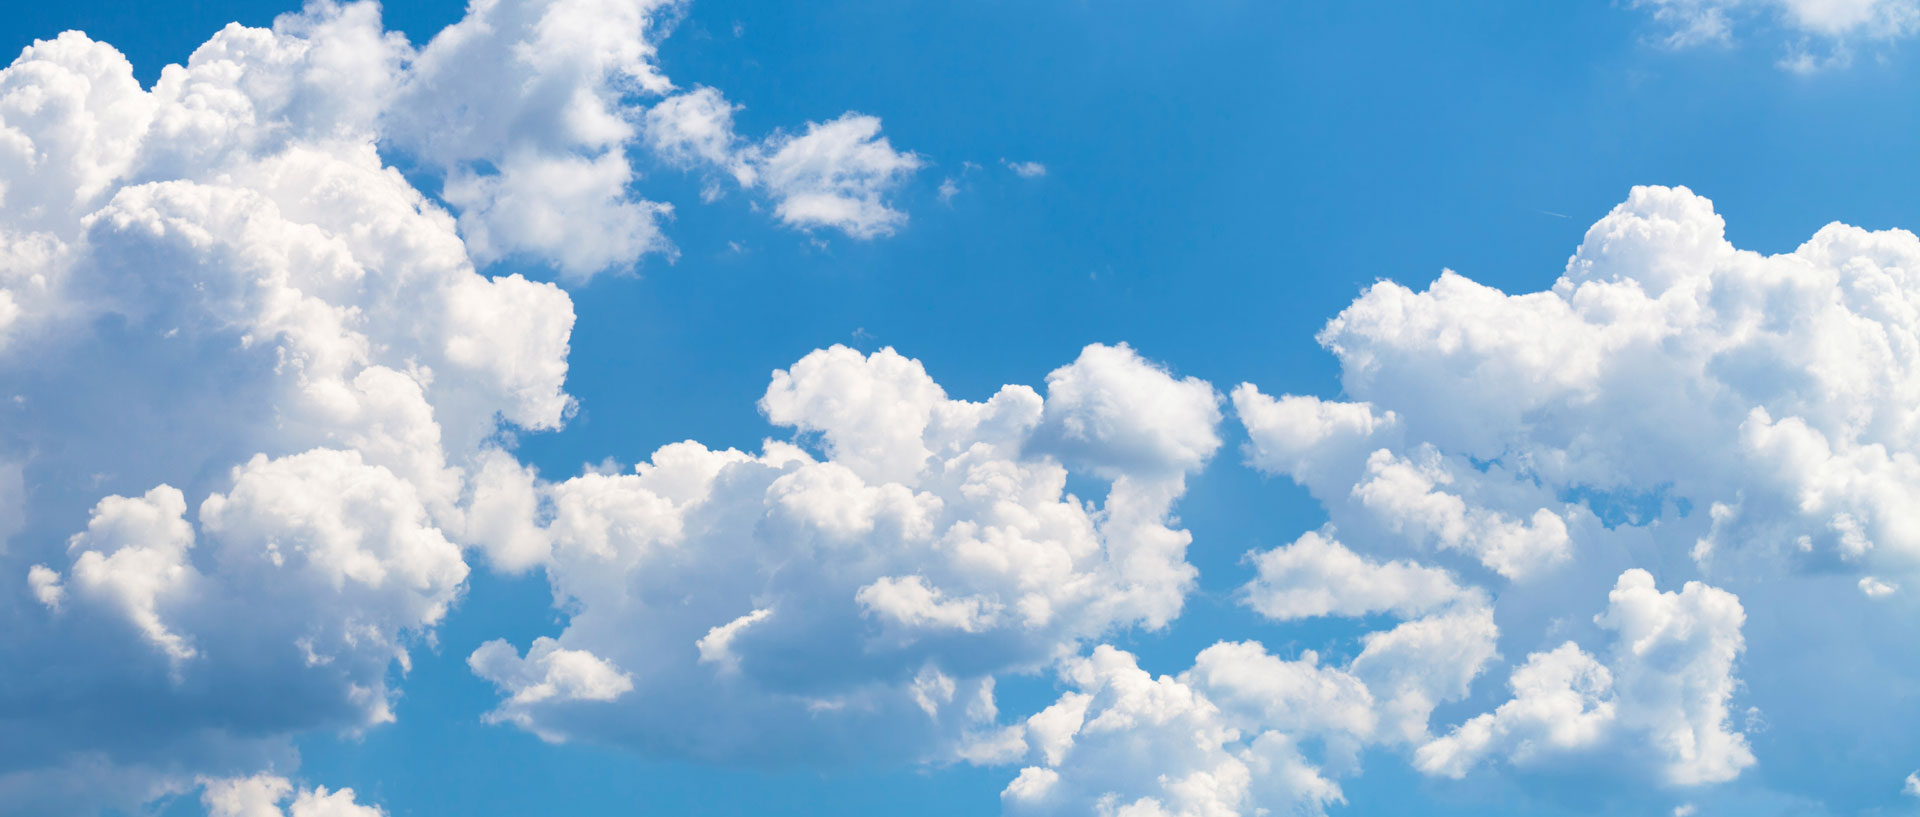

In [59]:
content_image = load_image('../data/clouds.jpg', size=None)# .reshape((1,image_size,image_size,3))[0]
# content_image = np.random.uniform(size=[512,512,3])

print content_image.shape
# content_layer = vgg.conv5_4[0]
# session.run(image.assign(content_image))
# content_layer.get_shape()
# content_layer_activations = session.run(content_layer)
to_pil(content_image)

In [43]:
def resize(img, size):
    h,w = size
    scale = [h * 1.0 / img.shape[0], w * 1.0 / img.shape[1], 1]
    # print scale
    result = scipy.ndimage.zoom(img, scale)
    # print result.shape[:2], (h,w)
    assert result.shape[:2] == (h,w)
    return result

# to_pil(resize(content_image, [1024, 1024]))

0
1
2
3


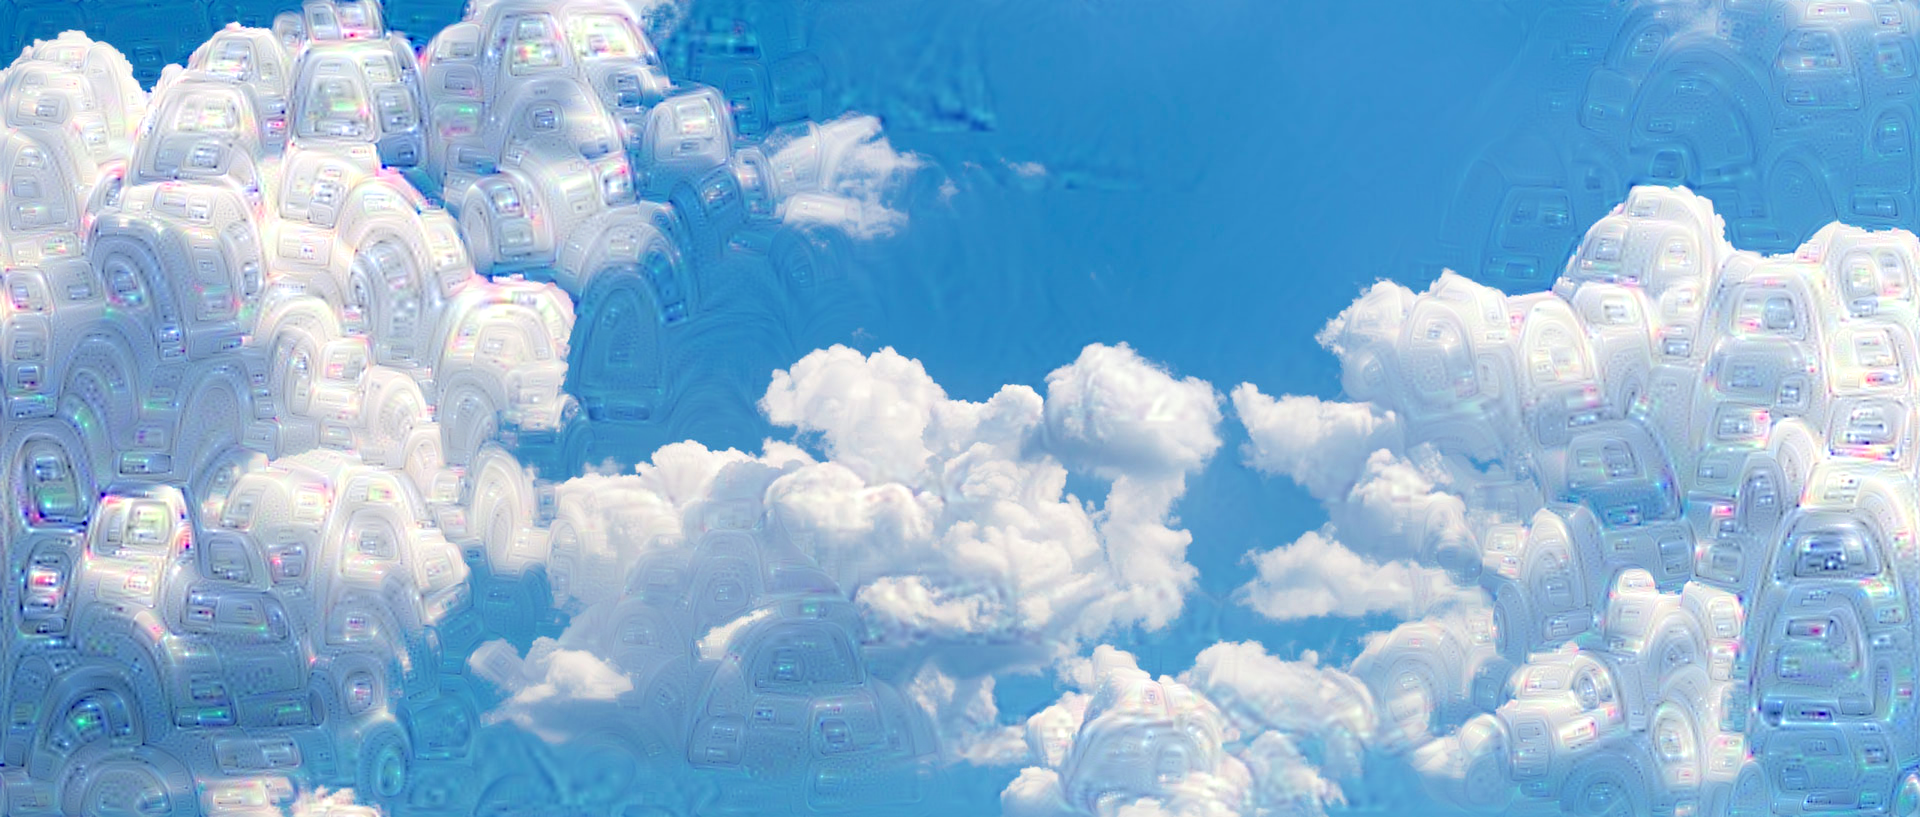

In [64]:
# from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            h,w = sub.shape[:2]
            sub_padded = np.pad(sub, [(0, 512 - h), (0, 512 - w), (0, 0)], 'edge')
            g = session.run(t_grad, {image_placeholder: np.array([sub_padded])})[:,:h,:w,:]
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def dream(image, layer, channel, steps=20, step_size=0.001, octaves=4, octave_scale=1.5):
    gradient = tf.gradients(tf.reduce_mean(layer[0,:,:,channel]), [image_placeholder])[0]
    
    hi_freq_images = []
    for octave in xrange(octaves - 1):
        new_size = (int(image.shape[0] / octave_scale), int(image.shape[1] / octave_scale))
        lo = resize(image, new_size)
        hi = image - resize(lo, image.shape[:2])
        hi_freq_images.append(hi)
        image = lo
    # now image is small, and hi_freq_images is a list of increasingly large images containing the high frequencies
    
    for i in xrange(octaves):
        print i
        if i > 0:
            hi = hi_freq_images[-i]
            image = resize(image, hi.shape[:2]) + hi
        for j in xrange(steps):
            # print i,j
            h,w = image.shape[:2]
            # image_padded = np.pad(image, [(0, 512 - h), (0, 512 - w), (0, 0)], 'edge')
            # g = session.run(gradient, {image_placeholder: np.array([image_padded])})[0,:h,:w]
            g = calc_grad_tiled(image, gradient)
            image += g * step_size / (np.abs(g).mean() + 0.0001)
    return image
        

d = dream(content_image, vgg.conv5_3, 7)
to_pil(d)